# Analisis previo

Explorando los datos del conjunto de datos de viernes negro para conocer las características que podemos usar para predecir las compras de los clientes.

In [1]:
# importando librerias necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df = pd.read_csv('datasets/BlackFriday.csv', sep=',')
df.sample(3)

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
227677,1005086,P00320442,M,26-35,1,C,0,1,6,10.0,NaN,20481
67877,1004386,P00212142,M,26-35,5,B,1,0,8,NaN,NaN,7885
362573,1001796,P00084242,M,51-55,11,C,2,1,8,14.0,NaN,6005


# Tamaño del dataset y valores nulos

Vamos a dar un rapido vistazo a los datos

In [3]:
df.shape

(537577, 12)

In [4]:
df.columns

Index(['User_ID', 'Product_ID', 'Gender', 'Age', 'Occupation', 'City_Category',
       'Stay_In_Current_City_Years', 'Marital_Status', 'Product_Category_1',
       'Product_Category_2', 'Product_Category_3', 'Purchase'],
      dtype='object')

In [5]:
# confirmando si mi conjunto tiene valores nulos
df.isnull().sum()

User_ID                            0
Product_ID                         0
Gender                             0
Age                                0
Occupation                         0
City_Category                      0
Stay_In_Current_City_Years         0
Marital_Status                     0
Product_Category_1                 0
Product_Category_2            166986
Product_Category_3            373299
Purchase                           0
dtype: int64

In [6]:
# veamos la cantidad de datos perdidos de las categorias 2 y 3 en relacion con el total
pc2 = df['Product_Category_2'].isnull().sum() /len(df)
pc3 = df['Product_Category_3'].isnull().sum() /len(df)

print('Total rows: {}\nProd2 Missing: {:.0%}\nProd3 Missing: {:.0%}'.format(len(df), pc2, pc3))

Total rows: 537577
Prod2 Missing: 31%
Prod3 Missing: 69%


El porcentaje de datos faltantes en la categoria producto 3, es casi el 70%. 
Si deseamos mantener esta columna debemos reemplazar o rellenar los valores faltantes. Como ambas columnas representan datos categóricos, podemos crear una nueva categoría que represente los valores perdidos o podemos eliminar estas dos variables, ya que no son imprescindibles para nuestro analisis.

In [7]:
df.drop('Product_Category_2', axis=1, inplace=True)
df.drop('Product_Category_3', axis=1, inplace=True)

## Tipos de datos del dataset

Necesitamos conocer los tipos de datos del conjunto y la distribución de las características. Esto nos ayudará a decidir como atacar el problema.

In [8]:
# el tipo object representa usualmente a los datos almacenados como string
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 537577 entries, 0 to 537576
Data columns (total 10 columns):
User_ID                       537577 non-null int64
Product_ID                    537577 non-null object
Gender                        537577 non-null object
Age                           537577 non-null object
Occupation                    537577 non-null int64
City_Category                 537577 non-null object
Stay_In_Current_City_Years    537577 non-null object
Marital_Status                537577 non-null int64
Product_Category_1            537577 non-null int64
Purchase                      537577 non-null int64
dtypes: int64(5), object(5)
memory usage: 41.0+ MB


In [9]:
df.describe()

,User_ID,Occupation,Marital_Status,Product_Category_1,Purchase
count,5.375770e+05,537577.00000,537577.000000,537577.000000,537577.000000
mean,1.002992e+06,8.08271,0.408797,5.295546,9333.859853
std,1.714393e+03,6.52412,0.491612,3.750701,4981.022133
min,1.000001e+06,0.00000,0.000000,1.000000,185.000000
25%,1.001495e+06,2.00000,0.000000,1.000000,5866.000000
50%,1.003031e+06,7.00000,0.000000,5.000000,8062.000000
75%,1.004417e+06,14.00000,1.000000,8.000000,12073.000000
max,1.006040e+06,20.00000,1.000000,18.000000,23961.000000


## Caracteristicas de los datos

Ahora vamos a ver el comportamiento de nuestros datos por categoria o variable:

### User_ID y Product_ID

In [10]:
unique_users = len(df.User_ID.unique())
unique_products = len(df.Product_ID.unique())
print('There are {} unique users and {} unique products'.format(unique_users, unique_products))

There are 5891 unique users and 3623 unique products


In [11]:
user_x_product = df['Product_ID'].groupby(df['User_ID']).count()
user_x_product.sort_values(inplace=True, ascending=False)

# top cinco de comprados
print(user_x_product[:5])


User_ID
1001680    1025
1004277     978
1001941     898
1001181     861
1000889     822
Name: Product_ID, dtype: int64


Para tener en cuenta: USER_ID se representa como un entero, pero esto no es realmente una característica numérica. Los usuarios con números de identificación más cercanos no necesariamente muestran los mismos patrones de comportamiento. Esta columna es categórica.

## Gender, Age, Occupation, y City_Category

Vamos a obtener el total de caracteristicas de cada categoria, graficarlas y para el proceso de predicción las normalizamos.

In [12]:
# podemos imprimir todas las categorias, pero hay otras formas más elegantes
for col_name in ['Gender', 'Age', 'Occupation', 'City_Category']:
    print(sorted(df[col_name].unique()))

['F', 'M']
['0-17', '18-25', '26-35', '36-45', '46-50', '51-55', '55+']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
['A', 'B', 'C']


In [13]:
df.groupby(['Gender']).agg(['count'])

,User_ID,Product_ID,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Purchase
,count,count,count,count,count,count,count,count,count
Gender,,,,,,,,,
F,132197,132197,132197,132197,132197,132197,132197,132197,132197
M,405380,405380,405380,405380,405380,405380,405380,405380,405380


In [14]:
df['Gender'].value_counts()

M    405380
F    132197
Name: Gender, dtype: int64

In [15]:
# otra forma de hacer lo mismo, pero teniendo unarray
df['Gender'].unique()

array(['F', 'M'], dtype=object)

In [16]:
df.groupby(['City_Category']).agg(['count'])

,User_ID,Product_ID,Gender,Age,Occupation,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Purchase
,count,count,count,count,count,count,count,count,count
City_Category,,,,,,,,,
A,144638,144638,144638,144638,144638,144638,144638,144638,144638
B,226493,226493,226493,226493,226493,226493,226493,226493,226493
C,166446,166446,166446,166446,166446,166446,166446,166446,166446


In [17]:
df['City_Category'].unique()

array(['A', 'C', 'B'], dtype=object)

In [18]:
df['City_Category'].value_counts()

B    226493
C    166446
A    144638
Name: City_Category, dtype: int64

In [19]:
df.groupby(['Age']).agg(['count'])

,User_ID,Product_ID,Gender,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Purchase
,count,count,count,count,count,count,count,count,count
Age,,,,,,,,,
0-17,14707,14707,14707,14707,14707,14707,14707,14707,14707
18-25,97634,97634,97634,97634,97634,97634,97634,97634,97634
26-35,214690,214690,214690,214690,214690,214690,214690,214690,214690
36-45,107499,107499,107499,107499,107499,107499,107499,107499,107499
46-50,44526,44526,44526,44526,44526,44526,44526,44526,44526
51-55,37618,37618,37618,37618,37618,37618,37618,37618,37618
55+,20903,20903,20903,20903,20903,20903,20903,20903,20903


In [20]:
df['Age'].unique()

array(['0-17', '55+', '26-35', '46-50', '51-55', '36-45', '18-25'],
      dtype=object)

In [21]:
df['Age'].value_counts()

26-35    214690
36-45    107499
18-25     97634
46-50     44526
51-55     37618
55+       20903
0-17      14707
Name: Age, dtype: int64

In [22]:
df.groupby(['Marital_Status']).agg(['count'])

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Product_Category_1,Purchase
,count,count,count,count,count,count,count,count,count
Marital_Status,,,,,,,,,
0,317817,317817,317817,317817,317817,317817,317817,317817,317817
1,219760,219760,219760,219760,219760,219760,219760,219760,219760


In [23]:
df['Marital_Status'].unique()

array([0, 1], dtype=int64)

In [24]:
df['Marital_Status'].value_counts()

0    317817
1    219760
Name: Marital_Status, dtype: int64

In [25]:
# df.groupby(['Occupation']).agg(['count'])

df['Occupation'].unique()

array([10, 16, 15,  7, 20,  9,  1, 12, 17,  0,  3,  4, 11,  8, 19,  2, 18,
        5, 14, 13,  6], dtype=int64)

In [26]:
df['Occupation'].value_counts()

4     70862
0     68120
7     57806
1     45971
17    39090
20    32910
12    30423
14    26712
2     25845
16    24790
6     19822
3     17366
10    12623
5     11985
15    11812
11    11338
19     8352
13     7548
18     6525
9      6153
8      1524
Name: Occupation, dtype: int64

In [27]:
df.groupby(['Stay_In_Current_City_Years']).agg(['count'])


,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Marital_Status,Product_Category_1,Purchase
,count,count,count,count,count,count,count,count,count
Stay_In_Current_City_Years,,,,,,,,,
0,72725,72725,72725,72725,72725,72725,72725,72725,72725
1,189192,189192,189192,189192,189192,189192,189192,189192,189192
2,99459,99459,99459,99459,99459,99459,99459,99459,99459
3,93312,93312,93312,93312,93312,93312,93312,93312,93312
4+,82889,82889,82889,82889,82889,82889,82889,82889,82889


Esta variable es de especial cuidado. La representación es de hecho un número entero, pero existe una categoría que agrupa a todos los clientes que han estado viviendo en la ciudad durante más de 4 años. Esto plantea un desafío con respecto a cómo representar esta característica particular.

Por un lado, la inclinación natural sería representarlo como una columna numérica para capturar la función lineal (cuanto más tiempo han vivido los clientes en la ciudad, más probable es que exhiban algún comportamiento). Para lograr este efecto, tendrá que convertir los valores de 4+ datos como un entero (simplemente 4). Sin embargo perderemos información y crearemos cierta distorsión. ¿Qué pasa si la mayoría de los clientes en la categoría 4+ han vivido en la ciudad por más de 10 años? Piense en cómo la distribución de los años actuales pasados ​​en la ciudad por los clientes con la categoría "4+ años" puede influir en sus supuestos de linealidad.

El otro enfoque sería tratar esta columna como una columna categórica. Ahora, esto es muy factible porque el número de categorías es pequeño (5). Sin embargo, perderemos esta relación lineal en el proceso. Tendremos que pensar en ello. Como no puedo tomar una decisión en esta fase, dejaría la representación de la columna como una cadena y seguiría adelante.

In [28]:
df['Stay_In_Current_City_Years'].value_counts()

1     189192
2      99459
3      93312
4+     82889
0      72725
Name: Stay_In_Current_City_Years, dtype: int64

# visualizacion

veamos cómo se distribuyen los datos de cada columna de características de forma grafica. Para columnas con un número pequeño de categorías únicas, usaremos un gráfico de barras para visualizar cuántas filas tiene cada cateogry y para columnas con un número mayor de categorías usaremos histogramas.

In [29]:
for col_name in df.columns:
    print(col_name, len(df[col_name].unique()))

User_ID 5891
Product_ID 3623
Gender 2
Age 7
Occupation 21
City_Category 3
Stay_In_Current_City_Years 5
Marital_Status 2
Product_Category_1 18
Purchase 17959


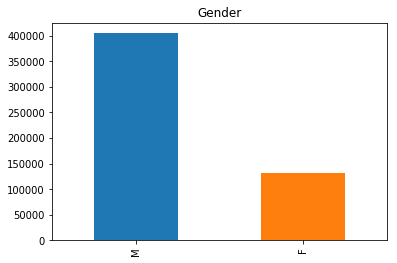

In [30]:
plt.figure()
df['Gender'].value_counts().plot(kind='bar', title='Gender')


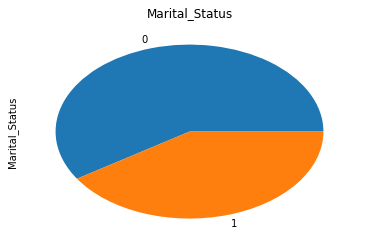

In [31]:
df['Marital_Status'].value_counts().plot(kind='pie', title='Marital_Status')

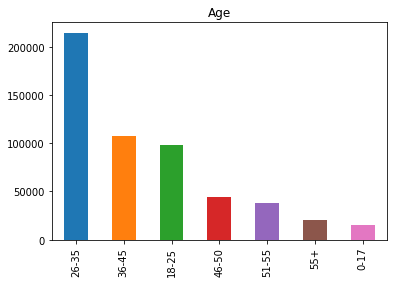

In [32]:
df['Age'].value_counts().plot(kind='bar', title='Age', stacked=True)
plt.show()

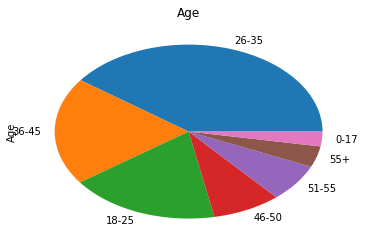

In [33]:
df['Age'].value_counts().plot(kind='pie', title='Age', stacked=True)
plt.show()

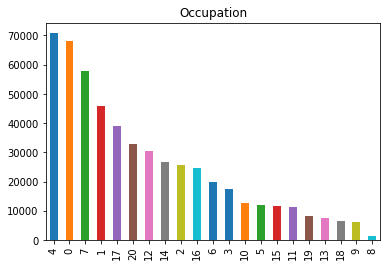

In [34]:
df['Occupation'].value_counts().plot(kind='bar', title='Occupation')

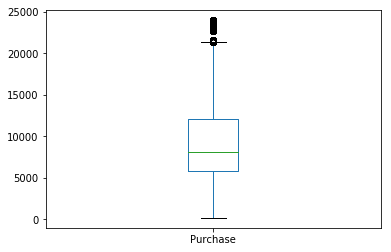

In [35]:
df['Purchase'].plot.box()

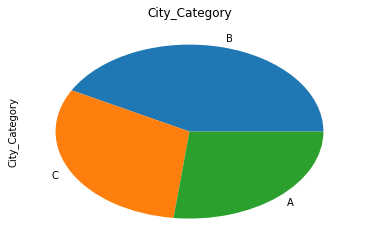

In [36]:
df['City_Category'].value_counts().plot(kind='pie', title='City_Category')

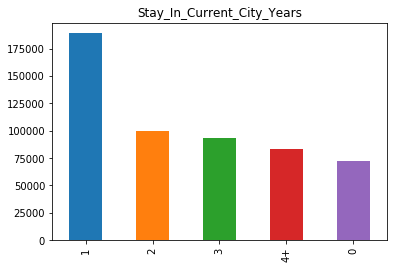

In [37]:
df['Stay_In_Current_City_Years'].value_counts().plot(kind='bar', title='Stay_In_Current_City_Years')

La categoría problemática 4+ no parece representar una gran parte de los clientes, lo que sugiere que incluso si la distribución interna de la categoría (que no conocemos) puede distorsionar la categoría, podría ser una buena idea representar la característica numéricamente.

# Histogramas 

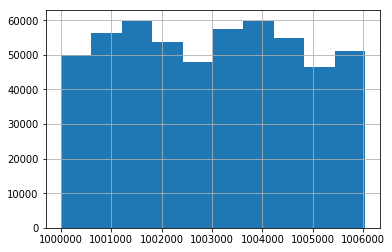

In [38]:
df['User_ID'].hist()

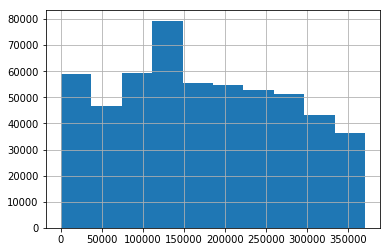

In [39]:
df['Product_ID'].apply(lambda x:int(x[1:])).hist()

### Convert object dtypes to numerical dtype for further computation

In [40]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

### Dropping Depended var

In [41]:
y = df['Purchase']
df.drop('Purchase', axis=1, inplace=True)

In [44]:
# vamos a normalizar los datos

gender_dict = {'F':0, 'M':1}
age_dict = {'0-17':0, '18-25':1, '26-35':2, '36-45':3, '46-50':4, '51-55':5, '55+':6}
city_dict = {'A':0, 'B':1, 'C':2}
stay_dict = {'0':0, '1':1, '2':2, '3':3, '4+':4}

In [45]:
df["Gender"] = df["Gender"].apply(lambda x: gender_dict[x])

df["Age"] = df["Age"].apply(lambda x: age_dict[x])

df["City_Category"] = df["City_Category"].apply(lambda x: city_dict[x])

df["Stay_In_Current_City_Years"] = df["Stay_In_Current_City_Years"].apply(lambda x: stay_dict[x])

Ya tenemos nuestro analisis completo y ahora vamos a calcular unas variables necesarias para nuestra predicción:

```python
Age_Count
Occupation_Count
Product_Category_1_Count
User_ID_Count
Product_ID_Count
```

In [54]:
def getCountVar(compute_df, count_df, var_name):
	grouped_df = count_df.groupby(var_name)
	count_dict = {}
	for name, group in grouped_df:
		count_dict[name] = group.shape[0]

	count_list = []
	for index, row in compute_df.iterrows():
		name = row[var_name]
		count_list.append(count_dict.get(name, 0))
	return count_list

In [55]:
df["Age_Count"] = getCountVar(df, df, "Age")
# test_df["Age_Count"] = getCountVar(test_df, train_df, "Age")

In [58]:
df["User_ID_Count"] = getCountVar(df, df, "User_ID")

In [59]:
df.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Age_Count,User_ID_Count
0,1000001,P00069042,0,0,10,0,2,0,3,14707,34
1,1000001,P00248942,0,0,10,0,2,0,1,14707,34
2,1000001,P00087842,0,0,10,0,2,0,12,14707,34
3,1000001,P00085442,0,0,10,0,2,0,12,14707,34
4,1000002,P00285442,1,6,16,2,4,0,8,20903,76
